In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
spark = SparkSession.builder.appName('Cybersecurity').getOrCreate()

In [ ]:
# Carregar o arquivo CSV
ataques_ciberneticos = spark.read.csv('/content/drive/MyDrive/ProjetoSemantix/Global_Cybersecurity_Threats_2015-2024.csv', header=True, inferSchema=True)

In [ ]:
ataques_ciberneticos.printSchema()
ataques_ciberneticos.show(5)

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Attack Type: string (nullable = true)
 |-- Target Industry: string (nullable = true)
 |-- Financial Loss (in Million $): double (nullable = true)
 |-- Number of Affected Users: integer (nullable = true)
 |-- Attack Source: string (nullable = true)
 |-- Security Vulnerability Type: string (nullable = true)
 |-- Defense Mechanism Used: string (nullable = true)
 |-- Incident Resolution Time (in Hours): integer (nullable = true)

+-------+----+-----------------+------------------+-----------------------------+------------------------+-------------+---------------------------+----------------------+-----------------------------------+
|Country|Year|      Attack Type|   Target Industry|Financial Loss (in Million $)|Number of Affected Users|Attack Source|Security Vulnerability Type|Defense Mechanism Used|Incident Resolution Time (in Hours)|
+-------+----+-----------------+------------------+-----------------

## 2. Limpeza e padronozacao

In [ ]:
# Remover linhas com valores nulos
ataques_ciberneticos = ataques_ciberneticos.dropna()

In [ ]:
# Verificar se há colunas duplicadas ou desnecessárias
ataques_ciberneticos = ataques_ciberneticos.dropDuplicates()

In [ ]:
# Renomear colunas para um padrão
for col_name in ataques_ciberneticos.columns:
    ataques_ciberneticos = ataques_ciberneticos.withColumnRenamed(col_name, col_name.lower().replace(' ', '_'))

ataques_ciberneticos.show(5)

+---------+----+-----------------+------------------+-----------------------------+------------------------+-------------+---------------------------+----------------------+-----------------------------------+
|  country|year|      attack_type|   target_industry|financial_loss_(in_million_$)|number_of_affected_users|attack_source|security_vulnerability_type|defense_mechanism_used|incident_resolution_time_(in_hours)|
+---------+----+-----------------+------------------+-----------------------------+------------------------+-------------+---------------------------+----------------------+-----------------------------------+
|   Brazil|2018|         Phishing|        Healthcare|                        99.14|                  456432|      Insider|             Weak Passwords|             Antivirus|                                 66|
|    Japan|2022|             DDoS|Telecommunications|                        34.31|                  305329|      Unknown|         Unpatched Software|          

# ANALISE 1: EVOLUCAO TEMPORAL DAS AMEACAS

##### A evolucao da quantidade de ameacas durante os anos

In [ ]:
# contar a agrupar as ocorrencias por ano
ataques_por_ano = ataques_ciberneticos.groupBy('year').count().orderBy('year')

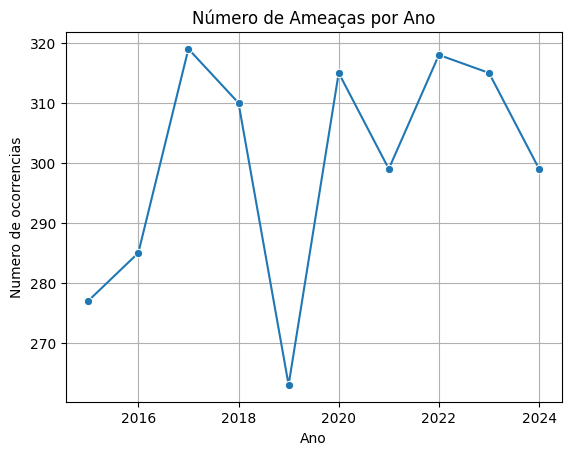

In [ ]:
ataques_por_ano_pd = ataques_por_ano.toPandas()
sns.lineplot(data = ataques_por_ano_pd, x = 'year', y = 'count', marker = 'o')
plt.title('Número de Ameaças por Ano')
plt.xlabel('Ano')
plt.ylabel('Numero de ocorrencias')
plt.grid(True)
plt.show()

# ANALISE 2: TIPOS DE AMEACAS

##### Quantidade de ataques agrupadas por tipo de ataque

In [ ]:
maiores_ameacas = ataques_ciberneticos.groupBy(
    'attack_type').count().orderBy(
        desc('count')).limit(10)

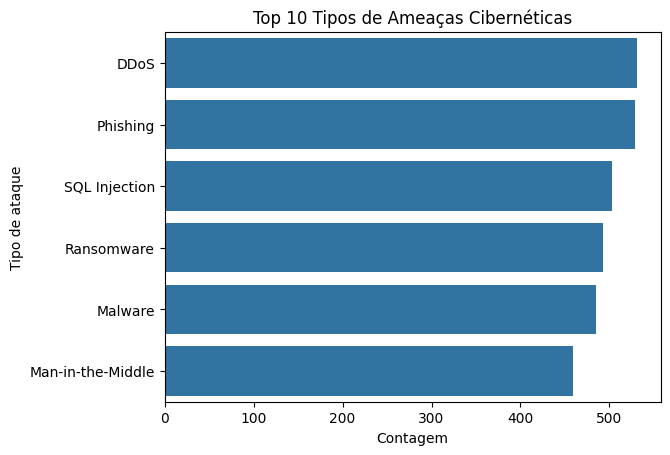

In [ ]:
maiores_ameacas_pd = maiores_ameacas.toPandas()
sns.barplot(data = maiores_ameacas_pd, y = 'attack_type', x = 'count')
plt.title('Top 10 Tipos de Ameaças Cibernéticas')
plt.xlabel('Contagem')
plt.ylabel('Tipo de ataque')
plt.show()

# ANALISE 3: DISTRIBUICAO POR REGIAO

##### Mostra, por pais, a quantidade de ataques hackers

In [ ]:
ataques_ciberneticos_geo = ataques_ciberneticos.groupBy(
    'country').count().orderBy(desc('count'))

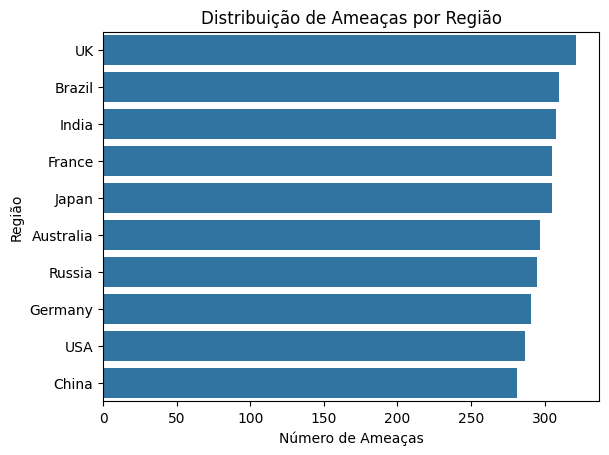

In [ ]:
ataques_ciberneticos_geo_pd = ataques_ciberneticos_geo.toPandas()
sns.barplot(data = ataques_ciberneticos_geo_pd, y = 'country', x = 'count')
plt.title('Distribuição de Ameaças por Região')
plt.xlabel('Número de Ameaças')
plt.ylabel('Região')
plt.show()

# ANALISE 4: PREVISAO DE AMEACAS FUTURAS

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [ ]:
# Dados por ano
data_ml = ataques_por_ano.withColumnRenamed('count', 'label')
vector = VectorAssembler(inputCols=['year'], outputCol='features')
data_ml = vector.transform(data_ml)

In [ ]:
# Modelo de regressão linear
lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(data_ml)
predicoes = lr_model.transform(data_ml)

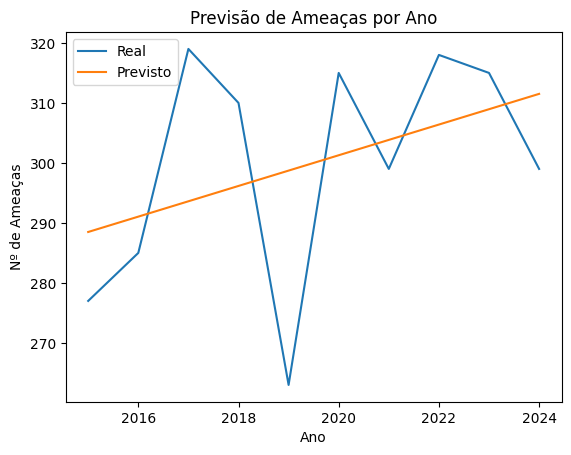

In [ ]:
df_pred = predicoes.select('year', 'label', 'prediction').toPandas()
sns.lineplot(data = df_pred, x = 'year', y = 'label', label = 'Real')
sns.lineplot(data = df_pred, x ='year', y = 'prediction', label = 'Previsto')
plt.title('Previsão de Ameaças por Ano')
plt.xlabel('Ano')
plt.ylabel('Nº de Ameaças')
plt.show()

Text(0, 0.5, 'Valor (em milhao) acumulado')

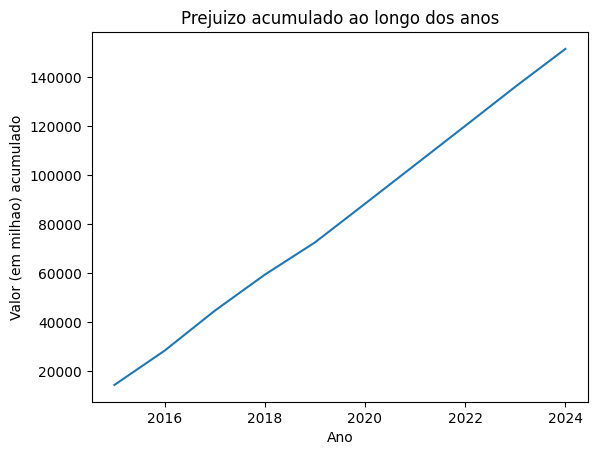

In [ ]:
# Prejuizo financeiro ao longo dos anos com ataques ciberneticos
prejuizo_paises_df = ataques_ciberneticos.groupBy('year').sum().orderBy('year')
prejuizo_paises = prejuizo_paises_df.toPandas()

# calculando o acumulado atraves dos anos
prejuizo_paises['acumulado'] = prejuizo_paises[
    'sum(financial_loss_(in_million_$))'].cumsum()

sns.lineplot(data = prejuizo_paises, x = 'year', y = 'acumulado')
plt.title('Prejuizo acumulado ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Valor (em milhao) acumulado')

In [ ]:
# Industrias mais visadas para ataques
frequencia = ataques_ciberneticos.groupBy('target_industry').count()
frequencia = frequencia.orderBy("count", ascending=False).toPandas()

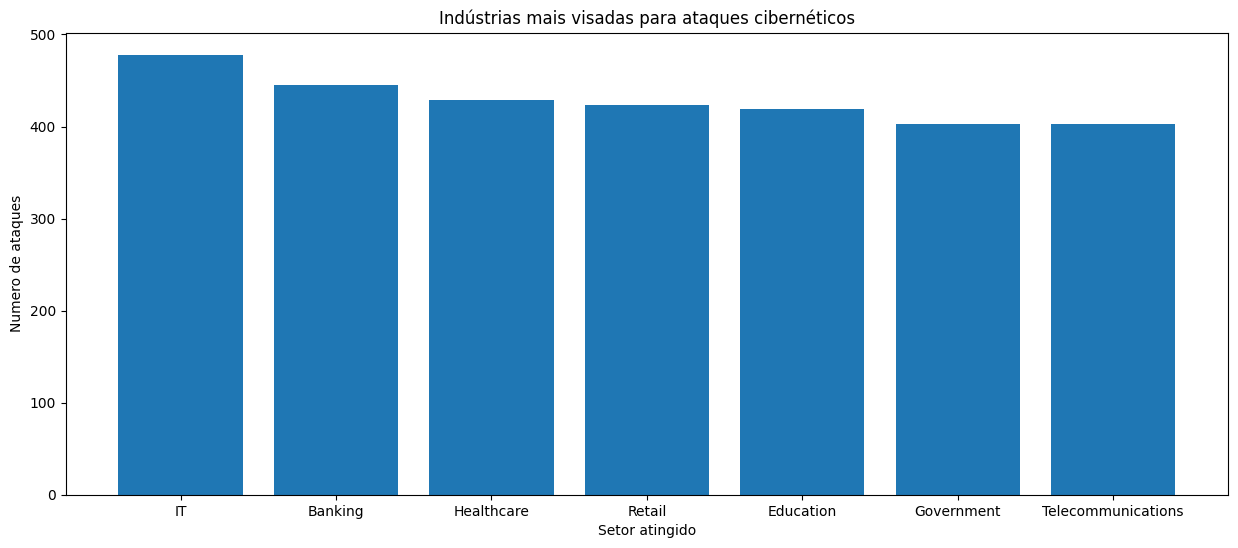

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(frequencia['target_industry'], frequencia['count'])
plt.title("Indústrias mais visadas para ataques cibernéticos")
plt.xlabel('Setor atingido')
plt.ylabel('Numero de ataques')
plt.show()

In [ ]:
# Tipo de defesas utilizadas para intervir
frequencia_defesa = ataques_ciberneticos.groupBy(
    'defense_mechanism_used').count()
frequencia_defesa = frequencia_defesa.toPandas()

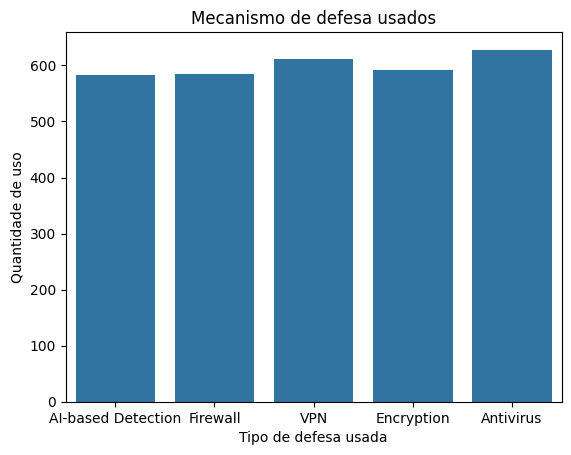

In [ ]:
sns.barplot(frequencia_defesa, x = 'defense_mechanism_used', y = 'count')
plt.title('Mecanismo de defesa usados')
plt.xlabel('Tipo de defesa usada')
plt.ylabel('Quantidade de uso')
plt.show()